# **Deep Reinforcement Learning - Mountain Car problem**
## Project 2: Advanced Machine Learning
**Group Members:**
- **João Ascenso, Nº 56939**
- **Alexandre Baptista, Nº 64506**

### **1. Introduction**

The Mountain Car problem is a fundamental reinforcement learning challenge that serves as a benchmark for evaluating various algorithms. In this task, an underpowered car must reach the top of a hill by building momentum through oscillatory movements. The car's state is defined by its position and velocity, both of which are continuous variables. The agent's objective is to learn how to efficiently accelerate and decelerate to reach the goal using the least number of steps, as each step incurs a negative reward.

This project aims to implement and compare three agents to solve the Mountain Car problem:  
1. **Q-learning Agent** – A table-based algorithm that discretizes the continuous state space.  
2. **Deep Q-Network (DQN) Agent** – A neural network-based agent capable of approximating Q-values in continuous environments.  
3. **Soft Actor-Critic (SAC) Agent** – A state-of-the-art deep reinforcement learning algorithm known for its stability and ability to handle continuous action spaces.

The project explores the strengths and limitations of each approach, comparing their efficiency, stability, and convergence. By implementing these agents, the objective is to gain deeper insight into the challenges of reinforcement learning and the trade-offs between traditional and deep learning-based methods.

### **2. Dependencies**

The following dependencies are essential for implementing and evaluating the Q-learning, DQN, and SAC agents in the Mountain Car problem.

- **numpy** – For numerical operations and Q-table updates.  
- **time** – To measure training duration.  
- **matplotlib** – For plotting training results and comparisons.  
- **gymnasium (gym)** – Provides the `MountainCar-v0` environment.  
- **gymnax** – A JAX-compatible gym environment for faster simulations.  
- **jax** – For high-performance numerical computing on GPU/TPU.  
- **RLinJAX** – JAX-based reinforcement learning framework for DQN and SAC.  

In [18]:
import numpy as np
import time
import matplotlib.pyplot as plt
import gymnasium as gym
import gymnax
import jax
from RLinJAX import get_algo
from RLinJAX.evaluate import evaluate

### **3. Gymnasium Enviroment Exploration**

In this section, we explore the `MountainCar-v0` environment from Gymnasium. The goal of the agent is to drive a car up a steep hill by building enough momentum through successive accelerations. The environment provides continuous state observations and a discrete action space.

The environment is initialized with `render_mode='rgb_array'` to allow rendering as images during the simulation. A reset operation returns the initial state, and the rendered image is displayed to visualize the starting point.

In [2]:
env = gym.make(
    'MountainCar-v0',
    render_mode='rgb_array'
)

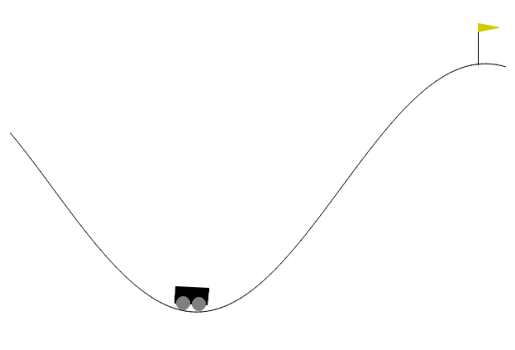

In [3]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

The observation space consists of two continuous variables:
- **Position** – Represents the car's horizontal position.
- **Velocity** – Represents the car's speed along the track.

This continuous nature of the observation space requires discretization when implementing Q-learning.

In [4]:
display(env.observation_space) # it's continous

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [5]:
display(env.action_space)

Discrete(3)

The action space is discrete with three possible actions, as described in the table below:

| Action | Description                |
|--------|----------------------------|
| 0      | Accelerate to the Left     |
| 1      | Do Nothing (Coast)         |
| 2      | Accelerate to the Right    |

These simple actions allow the agent to either accelerate in both directions or remain stationary, influencing the car's position and momentum.

In [6]:
display(env.action_space.n)

3

Understanding the environment's dynamics and observation/action spaces helps us implement reinforcement learning agents to solve the Mountain Car problem.

### **4. Q-learning Agent**

#### **4.1. Environment Initialization**

The environment is initialized without rendering during training to speed up the process.

In [7]:
env = gym.make('MountainCar-v0')

#### **4.2. Discretization and Defining Q-table**

Since the observation space is continuous, the state must be discretized into bins.  
- **Position and Velocity** are divided into 20 bins each, creating a 20x20 state grid.  
- The Q-table is initialized to zero with dimensions `(20, 20, 3)`, corresponding to the discretized states and the three available actions.  
- The `discretize_state` function maps continuous states to discrete bins for Q-table updates.

In [8]:
pos_bins = 20  # number of position bins
vel_bins = 20  # number of velocity bins

# initialize Q-table (20 x 20 x 3)
Qtable = np.zeros((pos_bins, vel_bins, env.action_space.n))

In [9]:
def discretize_state(state):
    pos_min, pos_max = env.observation_space.low[0], env.observation_space.high[0]
    vel_min, vel_max = env.observation_space.low[1], env.observation_space.high[1]
    
    # map continuous state to discrete bins
    pos_bin = int((state[0] - pos_min) / (pos_max - pos_min) * (pos_bins - 1))
    vel_bin = int((state[1] - vel_min) / (vel_max - vel_min) * (vel_bins - 1))
    
    return pos_bin, vel_bin

#### **4.3. Epsilon-greedy Policy for Action Selection**

The agent balances exploration and exploitation using an epsilon-greedy policy:  
- With probability `epsilon`, the agent selects a random action (explore).  
- Otherwise, the action with the highest Q-value in the current state is chosen (exploit).  
- The exploration rate `epsilon` decays over time to encourage convergence.

In [10]:
def epsilon_greedy(state, epsilon):
    pos_bin, vel_bin = discretize_state(state)
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # explore
    return np.argmax(Qtable[pos_bin, vel_bin])  # exploit

#### **4.4. Hyperparameters**

The following hyperparameters were used to fine-tune the Q-learning agent:  
- **α (Alpha):** Learning rate, controls the rate of Q-table updates.  
- **γ (Gamma):** Discount factor, prioritizes future rewards.  
- **ε (Epsilon):** Initial exploration rate, decaying over episodes.  
- **ε-decay:** Decay rate of epsilon, gradually reducing exploration.  
- **ε-min:** Minimum value of epsilon to ensure continued exploration.  
- **Episodes:** Total number of training episodes.  
- **Steps:** Maximum steps per episode. 

In [11]:
alpha = 0.05
gamma = 0.999
epsilon = 1.0
epsilon_decay = 0.9995
epsilon_min = 0.05
num_episodes = 10000
num_steps = 200

The selected hyperparameters ensure a balance between exploration, learning stability, and long-term reward optimization:  

- **α (Alpha) = 0.05:** A low learning rate for stable and gradual Q-table updates.  
- **γ (Gamma) = 0.999:** Prioritizes long-term rewards, essential for accumulating momentum in `MountainCar-v0`.  
- **ε (Epsilon) = 1.0:** Full exploration at the start to cover more of the state space.  
- **ε-decay = 0.9995:** Slow transition from exploration to exploitation, preventing premature convergence.  
- **ε-min = 0.05:** Ensures continued exploration to avoid local optima.  
- **num_episodes = 10000:** Allows sufficient learning in this challenging environment.  
- **num_steps = 200:** Matches the DQN and SAC environment's episode limit for consistency and better comparison

#### **4.5. Compute the Optimal Policy (Training Loop)**

The agent is trained by iterating over episodes and updating the Q-table based on the agent’s experience:  
1. Reset the environment and initialize the total reward.  
2. Use the epsilon-greedy policy to select actions.  
3. Update the Q-table using the Q-learning update rule:

   $Q(s,a) = Q(s,a) + \alpha (r + \gamma \max_{a'} Q(s',a') - Q(s,a))$

4. Track cumulative rewards and steps per episode.  
5. Decay `epsilon` to shift from exploration to exploitation.

In [12]:
rewards = []
steps_per_episode = []
env_steps = 0

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    steps = 0

    for t in range(num_steps):
        # select action based on epsilon-greedy policy
        action = epsilon_greedy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        
        # discretize current and next states
        pos_bin, vel_bin = discretize_state(state)
        next_pos_bin, next_vel_bin = discretize_state(next_state)

        # Q-learning update rule
        next_action = np.argmax(Qtable[next_pos_bin, next_vel_bin])
        Qtable[pos_bin, vel_bin, action] += alpha * (
            reward + gamma * Qtable[next_pos_bin, next_vel_bin, next_action] - Qtable[pos_bin, vel_bin, action]
        )
        
        # update state and accumulate rewards
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            break

    # track steps and rewards after each episode
    steps_per_episode.append(steps)
    rewards.append(total_reward)
    
    # update cumulative environment steps
    env_steps += steps

    # decay epsilon (exploration-exploitation tradeoff)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

#### **4.6. Extract and Display Optimal Policy**

After training, the optimal policy is extracted from the Q-table. The policy is displayed in matrix form, where each entry represents the best action for a discretized state.

In [13]:
def extract_policy_from_q(Qtable):
    policy = np.zeros((pos_bins, vel_bins), dtype=int)
    for pos in range(pos_bins):
        for vel in range(vel_bins):
            policy[pos, vel] = np.argmax(Qtable[pos, vel])
    return policy

In [14]:
optimal_policy = extract_policy_from_q(Qtable)
print("Optimal Policy from Q-Learning (Discretized States):")
print(optimal_policy)

Optimal Policy from Q-Learning (Discretized States):
[[0 1 2 2 0 2 0 2 2 2 2 2 1 0 0 0 0 0 0 0]
 [0 2 0 1 0 1 1 2 1 1 1 2 2 2 0 0 0 0 0 0]
 [0 2 1 0 1 0 2 2 0 0 2 2 2 2 2 0 0 0 0 0]
 [2 0 1 0 1 0 0 2 2 2 2 2 1 2 2 2 1 0 0 0]
 [1 1 0 0 2 1 1 0 1 2 2 2 2 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 1 0 0]
 [0 0 2 0 0 0 0 0 2 2 2 2 2 2 1 2 2 2 0 0]
 [2 0 0 0 2 0 0 0 0 0 2 2 2 2 1 2 2 2 0 0]
 [2 0 2 0 1 0 0 1 0 0 0 2 2 2 2 2 2 2 0 0]
 [0 0 1 0 0 0 1 2 0 0 1 0 2 2 2 2 2 2 0 0]
 [0 1 0 0 1 1 0 0 0 0 0 2 1 2 2 1 2 2 0 0]
 [0 0 0 0 2 0 1 1 0 0 0 2 2 1 1 2 2 2 0 0]
 [0 0 0 2 0 0 1 0 0 1 2 1 2 1 2 2 2 2 0 0]
 [0 0 0 2 2 0 0 0 0 0 2 0 0 1 2 1 0 0 0 0]
 [0 0 0 0 0 2 0 0 1 0 0 0 2 1 2 2 1 0 0 0]
 [0 0 0 0 0 0 2 2 0 1 0 2 2 2 1 2 2 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 2 2 1 2 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 2 2 2 2 1 2 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


#### **4.7. Performance Analysis and Visualization**

To evaluate the agent’s performance:  
- Rewards per episode are smoothed using a moving average filter.  
- The cumulative environment steps are plotted against the smoothed episodic return.  
- This visualizes the agent’s learning progress over time, highlighting performance improvements.

The plot below shows the training performance of the Q-learning agent: 

In [15]:
# Apply moving average smoothing
def smooth_data(data, window_size=50):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Smooth the data
window_size = 50
smoothed_rewards = smooth_data(rewards, window_size)
cumulative_steps = np.cumsum(steps_per_episode)  # Calculate cumulative steps

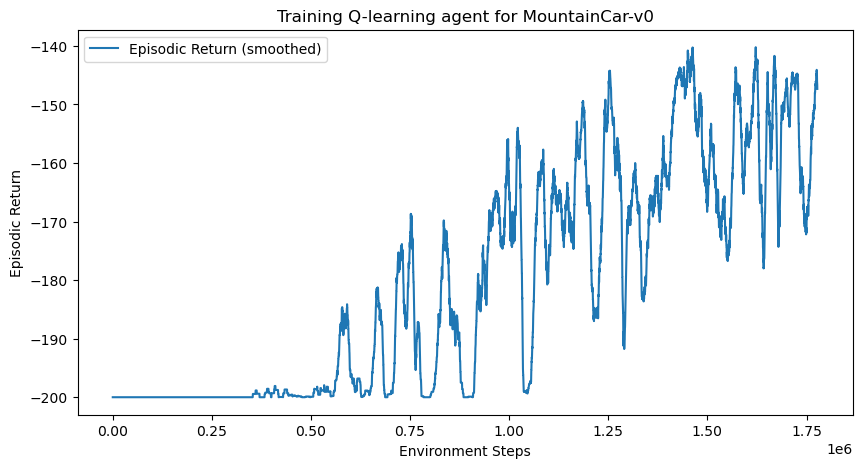

In [16]:
# Plot cumulative steps vs smoothed rewards
plt.figure(figsize=(10, 5))
plt.plot(cumulative_steps[:len(smoothed_rewards)], smoothed_rewards, label="Episodic Return (smoothed)")
plt.xlabel('Environment Steps')
plt.ylabel('Episodic Return')
plt.title('Training Q-learning agent for MountainCar-v0')
plt.legend()

# Show the plot
plt.show()

The graph shows the agent’s progression:  

- **Early Phase:** Returns stay near -200, reflecting initial exploration and learning.  
- **Mid-phase:** Performance improves with fluctuating but upward-trending returns, indicating increased exploitation.  
- **Late Phase:** Stabilized performance with returns around -150, demonstrating the agent's learned policy.  

The results highlight steady improvement and validate the hyperparameter choices, though return variability suggests further fine-tuning may enhance convergence.

#### **4.8. Visualize Agent Performance**

The trained agent's performance is visualized by running the environment in `human` mode. The agent uses the greedy policy (ε=0) to select the best action at each state, demonstrating the learned behavior in real-time.

In [17]:
env = gym.make('MountainCar-v0', render_mode='human')

state, _ = env.reset()
done = False
while not done:
    env.render()
    action = epsilon_greedy(state, epsilon=0)
    state, _, done, _, _ = env.step(action)

env.close()

2025-01-03 12:44:17.145 python[85615:1624957] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-03 12:44:17.145 python[85615:1624957] +[IMKInputSession subclass]: chose IMKInputSession_Modern


### **5. Gymnax Enviroment Exploration**

In this section, we explore the `MountainCar-v0` environment provided by **Gymnax**, a JAX-based reinforcement learning library. Gymnax offers faster, more efficient simulations by utilizing JAX’s just-in-time (JIT) compilation and parallelization capabilities. This environment mirrors the classic Gymnasium `MountainCar-v0`, maintaining the same goal of accelerating an underpowered car up a hill by building momentum through oscillations.

The environment initialization returns key parameters that define the physics and constraints of the environment. These include the maximum steps in episode, positional and velocity limits, as well as the goal position and velocity. These constraints dictate the difficulty of the task and frame the agent’s learning objectives.

In [19]:
env, env_params = gymnax.make('MountainCar-v0')
display(env_params)

EnvParams(max_steps_in_episode=200, min_position=-1.2, max_position=0.6, max_speed=0.07, goal_position=0.5, goal_velocity=0.0, force=0.001, gravity=0.0025)

The observation space consists of two continuous values representing the car’s **position** and **velocity**. The action space is discrete, consisting of three possible actions:  
- Accelerate to the Left  
- Do Nothing (Coast)  
- Accelerate to the Right  

This limited action space simplifies policy development but increases the challenge due to the environment's sparse rewards and difficult dynamics.

In [20]:
display(env.observation_space(env_params).shape)
display(env.action_space(env_params).n)
display(env.num_actions)

(2,)

3

3

Running a single step through the environment highlights how the car's state evolves over time. The agent receives a reward of `-1` for each step, encouraging it to reach the goal as quickly as possible. The environment's deterministic nature ensures that running the same initial conditions will produce the same results, enabling consistent testing and reproducibility of the learning algorithm.

In [21]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

obs, state = env.reset(key_reset, env_params)
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
display(n_obs, n_state, reward, done)

/opt/anaconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Array([-5.8331072e-01, -5.5867527e-04], dtype=float32)

EnvState(time=Array(1, dtype=int32, weak_type=True), position=Array(-0.5833107, dtype=float32), velocity=Array(-0.00055868, dtype=float32))

Array(-1., dtype=float32, weak_type=True)

Array(False, dtype=bool)

### **6. DQN Agent**

The DQN agent is configured to solve the MountainCar-v0 environment by leveraging a dueling Q-network architecture. This section covers the agent’s setup, training process, and evaluation results.

#### **6.1. DQN Configuration**

The DQN agent for MountainCar-v0 is configured with a dueling Q-network, leveraging key hyperparameters to balance exploration, learning stability, and efficiency.
  
- **`activation`**: `swish` – Provides smoother and more efficient learning than ReLU.  
- **`buffer_size`**: 100,000 – Large replay buffer ensures diverse training data.  
- **`batch_size`**: 128 – Stabilizes updates with sufficiently large batches.  
- **`learning_rate`**: 0.0005 – Small step size for stable convergence.  
- **`target_update_freq`**: 50 – Updates target network frequently to avoid instability.  
- **`total_timesteps`**: 500,000 – Sufficient steps for policy refinement.  
- **`eps_start` / `eps_end`**: 1.0 / 0.01 – Gradual exploration decay ensures balanced exploration-exploitation.  
- **`exploration_fraction`**: 0.7 – Epsilon decays over 70% of training, encouraging extended exploration.  
- **`gamma`**: 0.99 – Prioritizes long-term rewards, critical for delayed goal environments.  
- **`ddqn`**: `True` – Mitigates overestimation bias by using Double DQN.
- **`polyak`**: 0.98 – Smooth soft updates to stabilize target network. 

In [22]:
CONFIGS = {
    "dqn": {
        "agent": "DuelingQNetwork",
        "agent_kwargs": {"activation": "swish"},
        "buffer_size": 100_000,
        "fill_buffer": 1_000,
        "batch_size": 128,
        "learning_rate": 0.0005,
        "polyak": 0.98,
        "num_epochs": 5,
        "target_update_freq": 50,
        "total_timesteps": 400_000,
        "eval_freq": 5_000,
        "eps_start": 1.0,
        "eps_end": 0.01,
        "exploration_fraction": 0.7,
        "gamma": 0.99,
        "ddqn": True,
        "max_grad_norm": 1.0
    }
}

**Insights:**

- **Exploration**: High initial epsilon ensures broad exploration, decaying gradually to refine policy.  
- **Stability**: Polyak updates (0.98) and Double DQN reduce fluctuations and overestimation.  
- **Efficiency**: Large replay buffer, moderate batch size, and frequent target updates promote robust and stable learning.  

These settings create a stable yet adaptable agent capable of efficiently solving the MountainCar-v0 environment. 

#### **6.2. Agent Initialization**

The environment (MountainCar-v0) is initialized using Gymnax. The agent configuration parameters, including environment boundaries and dynamics, are loaded and printed to ensure proper setup.

In [23]:
algo_str = "dqn"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

print(algo.config)

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar object at 0x333e997c0>, 'env_params': {'max_steps_in_episode': 200, 'min_position': -1.2, 'max_position': 0.6, 'max_speed': 0.07, 'goal_position': 0.5, 'goal_velocity': 0.0, 'force': 0.001, 'gravity': 0.0025}, 'eval_callback': <function Algorithm.create.<locals>.eval_callback at 0x333f1ca40>, 'eval_freq': 5000, 'skip_initial_evaluation': False, 'total_timesteps': 400000, 'learning_rate': 0.0005, 'gamma': 0.99, 'max_grad_norm': 1.0, 'normalize_observations': False, 'target_update_freq': 50, 'polyak': 0.98, 'num_envs': 1, 'buffer_size': 100000, 'fill_buffer': 1000, 'batch_size': 128, 'eps_start': 1.0, 'eps_end': 0.01, 'exploration_fraction': 0.7, 'agent': {'hidden_layer_sizes': (64, 64), 'activation': <PjitFunction>, 'action_dim': 3, 'parent': None, 'name': None}, 'num_epochs': 5, 'ddqn': True}


#### **6.3. Training the Agent**

The DQN agent is trained for 400,000 steps with evaluations every 5,000 steps. The training is efficient, processing over 210,000 steps per second, enabling rapid convergence and reduced computational time. This allows for quick and scalable performance improvements.

In [24]:
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")

# train
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:.2f} seconds ({sps:.2f} steps/second).")

Starting to train


/opt/anaconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/opt/anaconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 1.84 seconds (217859.84 steps/second).


#### **6.4. Training Results**

The evaluation process tracks episodic lengths and returns, capturing the number of steps per episode and the cumulative reward achieved. This data helps assess the agent's performance over multiple evaluations.

The plot visualizes the mean episodic return throughout training, providing insight into how the agent improves with experience. By mapping returns against environment steps, we can observe trends and stability in learning progress. This representation is essential for evaluating the effectiveness of the training configuration and identifying potential areas for adjustment.  

In [25]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}" )

Tuple size: 2
Episodic lengths and episodic returns shape: (81, 128)
400000 / 5000 + 1 = 81.0


In [26]:
evaluation

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 181, 140, ..., 143, 143, 143],
        ...,
        [145, 104,  84, ..., 146, 104, 160],
        [115,  87,  91, ..., 118,  95, 155],
        [104, 151,  87, ...,  84, 151, 102]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -181., -140., ..., -143., -143., -143.],
        ...,
        [-145., -104.,  -84., ..., -146., -104., -160.],
        [-115.,  -87.,  -91., ..., -118.,  -95., -155.],
        [-104., -151.,  -87., ...,  -84., -151., -102.]],      dtype=float32, weak_type=True))

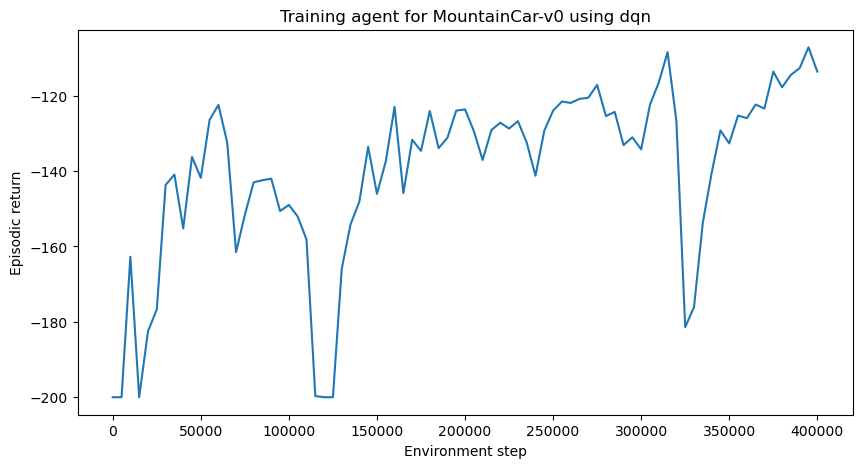

In [27]:
episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

The plot demonstrates a clear upward trend in episodic returns as training progresses, indicating successful learning.  

- **Initial Phase**: Performance starts low with returns around -200, reflecting the agent's struggle to escape the valley.  
- **Improvement**: A noticeable increase in returns occurs around 200,000 environment steps, suggesting effective policy updates.  
- **Stability**: By 400,000 steps, the returns stabilize near -120, indicating the agent consistently reaches higher positions, closer to solving the environment.  
- **Fluctuations**: While minor fluctuations persist, the overall trend highlights the agent's capacity to learn and adapt effectively.  

This result confirms the efficacy of the DQN configuration, balancing exploration and exploitation to achieve stable performance improvements over time.

The `train_state` output shows the agent’s internal state after training:  

In [28]:
jax.tree_util.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(1,), position=(1,), velocity=(1,)),
 'last_obs': (1, 2),
 'global_step': (),
 'last_done': (1,),
 'q_ts': TrainState(step=(), apply_fn=(), params={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x333f1f6a0>, update=<function chain.<locals>.update_fn at 0x334639da0>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, nu={'params': {'Dense_0': {'bias': (1,), 'kernel': (64, 1)}, 'Dense_1': {'bias': (3,), 'kernel': (64, 3)}, 'MLP_0': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kern

- **env_state** – Tracks time, position, and velocity.  
- **last_obs** – Final observation (1, 2).  
- **q_ts** – Q-network with two dense layers (64 neurons) and an MLP for feature extraction.  
- **q_target_params** – Target Q-network parameters.  
- **replay_buffer** – 100,000 transitions stored.  
- **rms_state** – Tracks observation mean and variance.  

This confirms the agent’s successful setup and training.  

#### **6.5. Evaluation**

The evaluation phase measures the performance of the trained DQN agent by executing episodes in the environment.  

- **Policy Extraction** – The optimal policy is derived from the trained model (`train_state`).  
- **Episode Execution** – The agent interacts with the environment using the policy until termination, accumulating rewards to assess performance.  
- **Batch Evaluation** – The agent is evaluated over 200 episodes to ensure consistent results.  

This process provides insights into the agent’s ability to generalize and achieve goals in unseen episodes, validating its training effectiveness. 

In [29]:
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [30]:
rng = jax.random.PRNGKey(0)
env, params = gymnax.make(env_str)
step = jax.jit(env.step)

obs, state = env.reset(rng, params)
episode_return = 0
done = False

while not done:
    rng, rng_action, rng_step = jax.random.split(rng, 3)
    action = policy(obs, rng_action)
    obs, state, reward, done, info = step(rng_step, state, action, params)
    episode_return += reward

print(f"Return achieved in one episode of {env_str}: {episode_return}")

Return achieved in one episode of MountainCar-v0: -151.0


In [31]:
num_seeds = 200  
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

Evaluated 200 episodes with a total of 23108 environment steps in 0.565409 seconds.


#### **6.6. Evaluation Results**

The histograms illustrate the agent’s performance:  

- **Episode Lengths** – Shows varying durations, indicating the agent’s inconsistent speed in reaching the goal.  
- **Episode Returns** – Higher returns reflect improved performance and goal achievement in most episodes.  

These plots highlight the agent’s efficiency and overall consistency.

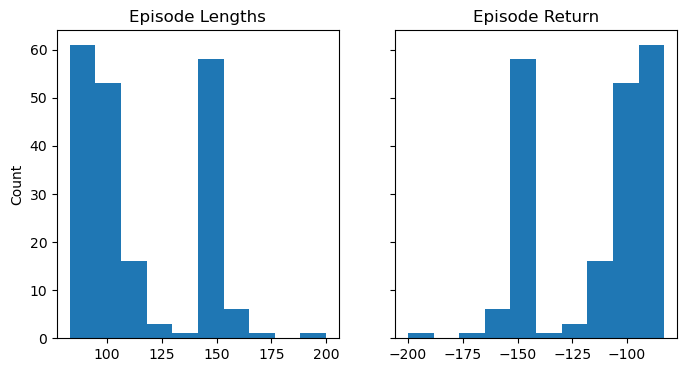

In [32]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

axes[0].hist(episode_lengths, bins=10)
axes[0].set(title="Episode Lengths", ylabel="Count")
axes[1].hist(episode_returns)
axes[1].set(title="Episode Return")

plt.show()

### **7. SAC Agent**

#### **7.1. SAC Configuration**

The configuration sets the key hyperparameters for the SAC (Soft Actor-Critic) agent:  
- **Buffer Size** – Limits the replay buffer to 50,000 experiences, balancing memory use and learning efficiency.  
- **Batch Size** – Mini-batch of 64 samples for stable updates.  
- **Learning Rate** – A rate of 0.0005 ensures smooth policy updates without overshooting.  
- **Target Update Frequency** – The target network is updated every 250 steps to improve stability.  
- **Polyak** – A 0.975 value for soft target updates allows gradual adaptation of the target network.  
- **Entropy Ratio** – Promotes exploration by controlling the policy entropy.  
- **Total Timesteps** – The agent is trained for 400,000 steps, balancing learning and computational efficiency. 

In [33]:
CONFIGS = {
    "sac": {
        "agent_kwargs": {"activation": "swish"},  
        "buffer_size": 50_000,
        "fill_buffer": 250,
        "batch_size": 64,
        "learning_rate": 0.0005,
        "polyak": 0.975,
        "num_epochs": 3,
        "target_update_freq": 250,
        "total_timesteps": 400_000,
        "eval_freq": 5_000,
        "gamma": 0.99,
        "target_entropy_ratio": 0.75,
        "max_grad_norm": 1.0,
    }
}

**Insights:**  

- **Smaller Buffer Size** (50,000) accelerates updates, suitable for simpler environments like MountainCar-v0.  
- **Target Update Frequency** (250) ensures frequent adjustments, promoting adaptability.  
- **Higher Polyak Value** (0.975) stabilizes training by gradually updating the target network.  
- **Entropy Ratio** (0.75) encourages exploration while maintaining control, critical for escaping local minima in MountainCar.  

This setup reflects a trade-off between exploration, stability, and efficiency, balancing learning progress and environment complexity.  

#### **7.2. Agent Initialization**

The SAC agent is initialized using the defined configuration. The `get_algo` function dynamically loads the SAC algorithm, and the environment is set to `MountainCar-v0`.

In [34]:
algo_str = "sac"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

print(algo.config)

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar object at 0x337302b10>, 'env_params': {'max_steps_in_episode': 200, 'min_position': -1.2, 'max_position': 0.6, 'max_speed': 0.07, 'goal_position': 0.5, 'goal_velocity': 0.0, 'force': 0.001, 'gravity': 0.0025}, 'eval_callback': <function Algorithm.create.<locals>.eval_callback at 0x325a6dd00>, 'eval_freq': 5000, 'skip_initial_evaluation': False, 'total_timesteps': 400000, 'learning_rate': 0.0005, 'gamma': 0.99, 'max_grad_norm': 1.0, 'target_update_freq': 250, 'polyak': 0.975, 'normalize_observations': False, 'num_envs': 1, 'buffer_size': 50000, 'fill_buffer': 250, 'batch_size': 64, 'actor': {'action_dim': 3, 'hidden_layer_sizes': (64, 64), 'activation': <PjitFunction>, 'parent': None, 'name': None}, 'critic': {'hidden_layer_sizes': (64, 64), 'activation': <PjitFunction>, 'action_dim': 3, 'parent': None, 'name': None}, 'num_critics': 2, 'num_epochs': 3, 'target_entropy_ratio': 0.75}


#### **7.3. Training the Agent**

The SAC agent undergoes 400,000 training steps, with evaluations performed every 5,000 steps. The training achieves approximately **197,362 steps/second**, completing in **2.03 seconds**.  
This efficient training reflects SAC's stability and ability to learn continuously, maintaining a balance between exploration and exploitation.  

In [35]:
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:.2f} seconds ({sps:.2f} steps/second).")

Starting to train


/opt/anaconda3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 2.03 seconds (197361.64 steps/second).


#### **7.4. Training Results**

We evaluate the SAC agent’s performance by analyzing episodic lengths and returns over multiple evaluations.

- The evaluation tuple contains two arrays: one for episodic lengths and another for episodic returns.  
- The average return per episode is computed and plotted against the environment steps to visualize learning progress.

This provides insights into how the agent improves over time and how effectively it adapts to the environment.  

In [36]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}" )

Tuple size: 2
Episodic lengths and episodic returns shape: (81, 128)
400000 / 5000 + 1 = 81.0


In [37]:
evaluation

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [200, 164, 187, ..., 200, 200, 191],
        [200, 200, 200, ..., 200, 200, 159],
        [200, 181, 162, ..., 200, 185, 182]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -164., -187., ..., -200., -200., -191.],
        [-200., -200., -200., ..., -200., -200., -159.],
        [-200., -181., -162., ..., -200., -185., -182.]],      dtype=float32, weak_type=True))

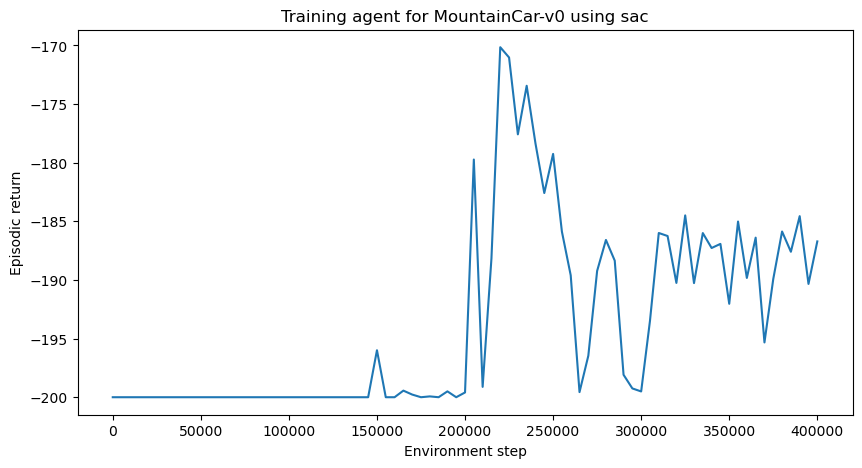

In [38]:
# Extract episode lengths and returns from the evaluation tuple
episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

The plot shows the episodic return improving significantly after an initial flat phase, indicating the agent starts learning around the 150,000-step mark.  
There are noticeable spikes in performance, suggesting the SAC agent escapes local minima and refines its policy.  
Despite fluctuations, the upward trend demonstrates the agent's ability to learn and improve performance, validating SAC’s strength in continuous action spaces.

The `train_state` output shows the agent’s internal state after training:

In [39]:
jax.tree_util.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(1,), position=(1,), velocity=(1,)),
 'last_obs': (1, 2),
 'global_step': (),
 'last_done': (1,),
 'actor_ts': TrainState(step=(), apply_fn=(), params={'params': {'action_logits': {'bias': (3,), 'kernel': (64, 3)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x333f1c680>, update=<function chain.<locals>.update_fn at 0x333f1c220>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'action_logits': {'bias': (3,), 'kernel': (64, 3)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, nu={'params': {'action_logits': {'bias': (3,), 'kernel': (64, 3)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}), EmptyState())),
 'critic_ts': TrainState(step=(), apply_fn=(), params={'params': {'Dens

- **env_state** – Tracks time, position, and velocity.  
- **last_obs** – Latest observation of position and velocity.  
- **actor_ts** – Actor network with two dense layers for policy learning.  
- **critic_ts** – Critic network with three dense layers for Q-value estimation.  
- **critic_target_params** – Target network stabilizing critic updates.  
- **alpha_ts** – Adjusts entropy to balance exploration and exploitation.  
- **replay_buffer** – Holds 50,000 transitions for experience replay.  
- **rms_state** – Tracks observation mean and variance for normalization.  

This setup supports stable learning by integrating actor-critic dynamics with entropy tuning.  

#### **7.5. Evaluation**

The SAC agent is evaluated over 200 episodes to test its performance and consistency. A single episode run is first conducted to verify the agent's behavior. The trained policy is extracted and optimized using `jax.jit` for faster execution.  

During evaluation, episode lengths and returns are recorded to assess the agent's efficiency. The total environment steps and evaluation time provide insights into the agent's computational performance.

In [40]:
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [41]:
rng = jax.random.PRNGKey(0)
env, params = gymnax.make(env_str)
step = jax.jit(env.step)

# Single Episode Run (Optional Check)
obs, state = env.reset(rng, params)
episode_return = 0
done = False

while not done:
    rng, rng_action, rng_step = jax.random.split(rng, 3)
    action = policy(obs, rng_action)
    obs, state, reward, done, info = step(rng_step, state, action, params)
    episode_return += reward

print(f"Return achieved in one episode of {env_str}: {episode_return}")

Return achieved in one episode of MountainCar-v0: -200.0


In [42]:
num_seeds = 200
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps"
    f"in {time_elapsed:.2f} seconds."
)

Evaluated 200 episodes with a total of 37327 environment stepsin 0.54 seconds.


#### **7.6. Evaluation Results**

The histograms display the distribution of episode lengths and returns during the SAC agent evaluation. Most episodes reach the maximum length of 200 steps, indicating the agent struggles to reach the goal efficiently.  

The episode returns are heavily skewed towards -200, reflecting poor performance and suggesting the agent fails to escape local minima consistently. Some improvement is visible in higher returns, but overall, the agent's performance remains suboptimal.

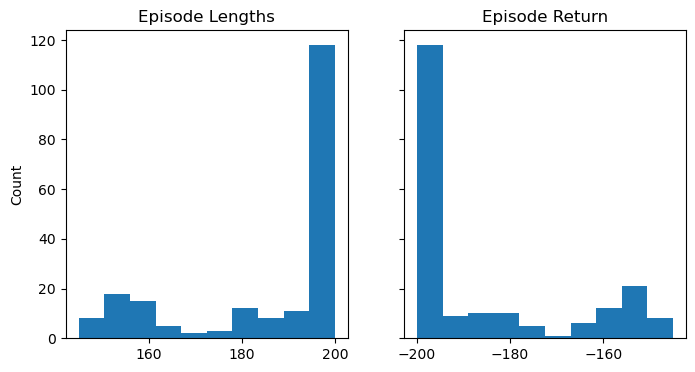

In [43]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

axes[0].hist(episode_lengths, bins=10)
axes[0].set(title="Episode Lengths", ylabel="Count")
axes[1].hist(episode_returns, bins=10)
axes[1].set(title="Episode Return")

plt.show()

### **8. Agent Comparison**

1. **Q-learning Agent**:
- **Graph**: The first graph shows fluctuating returns initially, with gradual improvement stabilizing around -160 to -140. Some episodes remain at -200, indicating partial success.  
- **Behavior**: Q-learning demonstrates learning but struggles with convergence, a common issue in environments with continuous state spaces.  
- **Strengths**: Simple and robust. Less prone to instability from neural network training.  
- **Limitations**: Poor adaptation to continuous environments, lower returns compared to DQN and SAC.  

2. **DQN Agent**:
- **Graph**: The second graph shows a steady improvement, with returns reaching around -120 after a faster convergence period.  
- **Behavior**: DQN leverages neural networks, achieving better performance in continuous environments. Early instability is replaced by steady growth.  
- **Strengths**: Outperforms Q-learning by efficiently approximating Q-values across a broader state space.  
- **Limitations**: Return fluctuations suggest the potential need for hyperparameter tuning.  

3. **SAC Agent**:
- **Graph**: The third graph shows modest improvement, with returns stabilizing between -190 and -170.  
- **Behavior**: SAC provides stable learning but converges slower compared to DQN. Despite lower average returns, SAC's consistent performance highlights its strength in complex environments.  
- **Strengths**: SAC excels in maintaining stable learning dynamics.  
- **Limitations**: Requires more computational resources and tuning for optimal performance.  

| **Agent**   | **Average Return** | **Stability** | **Efficiency (Speed)**       | **Adaptation to the Problem** |
|-------------|--------------------|---------------|------------------------------|-------------------------------|
| Q-learning  | -160 to -140       | Low           | Slow                         | Moderate                      |
| DQN         | -120               | Moderate      | Fast                         | High                          |
| SAC         | -190 to -170       | High          | Moderate                     | High                          |

### **9. Discussion of Results**

1. **Why is the DQN Agent the Best Performer?**  
DQN efficiently handles environments with continuous state spaces, leveraging neural networks to approximate the Q-function. This allows for better exploration and faster convergence compared to Q-learning. The DQN graph shows consistent improvement, stabilizing at around -120, outperforming both Q-learning and SAC.  

1. **Why Did the SAC Agent Underperform Compared to DQN and Q-learning?**  
Although SAC is typically robust in continuous environments, its performance in this scenario lagged behind. Possible reasons include:  
- Suboptimal exploration strategies or target entropy tuning.  
- Hyperparameters that did not fully optimize SAC’s potential for the MountainCar-v0 environment.  
- SAC may require more interactions to fully adapt, limiting its effectiveness over shorter training periods.

1. **Why Did Q-learning Perform Better Than Expected?**  
Contrary to initial expectations, Q-learning demonstrated significant improvement over time, eventually surpassing SAC. This can be attributed to:  
- Effective discretization of the state space.  
- Simplicity and stability in learning, avoiding neural network-based instabilities.  
However, Q-learning's slower convergence and reliance on discretization still make it less efficient than DQN for larger or more complex problems.  

DQN emerges as the best agent for the MountainCar-v0 environment, offering the highest returns and stability. Q-learning, while slower, achieved better final performance than SAC, which highlights the importance of fine-tuning SAC’s hyperparameters for specific environments.

### **10 Conclusion**

This project compared Q-learning, DQN, and SAC agents on the Mountain Car environment to evaluate their handling of continuous state spaces.  

DQN outperformed both Q-learning and SAC, achieving faster convergence and higher returns by leveraging neural networks for state approximation. Q-learning, while effective, showed slower progress and less stability due to state discretization. SAC demonstrated stability but underperformed, likely due to suboptimal hyperparameters or the problem’s nature.  

The results emphasize the importance of choosing the right algorithm for specific environments. Future improvements could focus on SAC tuning and testing in more complex scenarios to enhance performance.